In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random
import shutil
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from tqdm.notebook import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, roc_auc_score,
    roc_curve, precision_recall_curve, confusion_matrix,
)
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import seaborn as sns
from torchvision import models
from collections import defaultdict
from torchvision.models import vit_b_16, ViT_B_16_Weights
import timm

c:\Users\msaip\Projects\deep_fake\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

In [3]:
def extract_frames(video_path, num_frames=30):
    '''Function to extract frames from the video file.
        Args:
        video_path (str): Path to the video file.
        num_frames (int): Number of frames to extract.'''
    
    cap = cv2.VideoCapture(video_path)
    frame_count= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = list(np.linspace(0, frame_count-1, num_frames, dtype=int))

    frames = []
    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        if i in frame_idxs:
            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Resize frame to 224x224
            frame = cv2.resize(frame, (224, 224))
            # Normalize frame
            frame = frame / 255.0
            frames.append(frame)
        
    cap.release()
    return frames


def save_frames(dataset_path):
    '''Function to save the extracted frames to a directory.
        Args:
        dataset_path (str): Path to the dataset directory.'''
    
    videos = os.listdir(dataset_path)

    for video in videos:
        os.makedirs(f"{dataset_path}/{video.split('.')[0]}", exist_ok=True)
        video_path = os.path.join(dataset_path, video)
        frames = extract_frames(video_path, num_frames=30)

        for i, frame in enumerate(frames):
            plt.imsave(f"{dataset_path}/{video.split('.')[0]}/frame-{i}.jpg", frame)

        print(f"Frames extracted and saved for {video}")
    

In [4]:
def merge_directories(dir1, dir2, merged_dir):
    os.makedirs(merged_dir, exist_ok=True)

    for src_dir in [dir1, dir2]:
        for root, _, files in os.walk(src_dir):
            for file in files:
                src_path = os.path.join(root, file)
                
                # Optional: keep subfolders or flatten
                relative_path = os.path.relpath(root, src_dir)
                dest_folder = os.path.join(merged_dir, relative_path)
                os.makedirs(dest_folder, exist_ok=True)

                dest_path = os.path.join(dest_folder, file)
                
                if not os.path.exists(dest_path):  # avoid overwriting
                    shutil.copy2(src_path, dest_path)
                else:
                    # Rename if duplicate
                    base, ext = os.path.splitext(file)
                    new_filename = f"{base}_copy{ext}"
                    shutil.copy2(src_path, os.path.join(dest_folder, new_filename))

    print(f"[✔] Merged {dir1} and {dir2} into {merged_dir}")


merge_directories('real', 'YouTube-real', 'real')

[✔] Merged real and YouTube-real into real


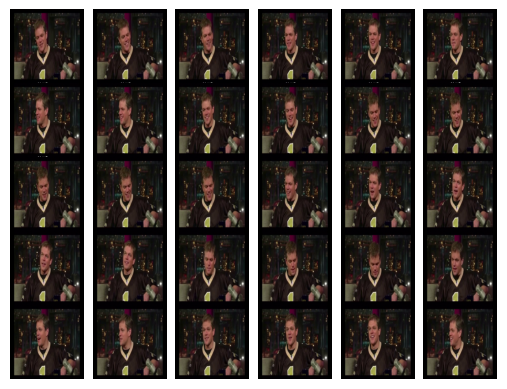

In [5]:
#Example usage of extract_frames function.
sample_frames = extract_frames('YouTube-real/00001.mp4')

for i in range(len(sample_frames)):
    plt.subplot(5, 6, i+1)
    plt.imshow(sample_frames[i])
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

In [6]:
celeb_real_path = 'real/'
celeb_synthesis_path = 'fake/'
youtube_real_path = 'YouTube-real/'

save_frames(celeb_real_path)
save_frames(celeb_synthesis_path)
save_frames(youtube_real_path)

Frames extracted and saved for 00000.mp4
Frames extracted and saved for 00001.mp4
Frames extracted and saved for 00002.mp4
Frames extracted and saved for 00003.mp4
Frames extracted and saved for 00004.mp4
Frames extracted and saved for 00005.mp4
Frames extracted and saved for 00006.mp4
Frames extracted and saved for 00007.mp4
Frames extracted and saved for 00008.mp4
Frames extracted and saved for 00009.mp4
Frames extracted and saved for 00010.mp4
Frames extracted and saved for 00011.mp4
Frames extracted and saved for 00012.mp4
Frames extracted and saved for 00013.mp4
Frames extracted and saved for 00014.mp4
Frames extracted and saved for 00015.mp4
Frames extracted and saved for 00016.mp4
Frames extracted and saved for 00017.mp4
Frames extracted and saved for 00018.mp4
Frames extracted and saved for 00019.mp4
Frames extracted and saved for 00020.mp4
Frames extracted and saved for 00021.mp4
Frames extracted and saved for 00022.mp4
Frames extracted and saved for 00023.mp4
Frames extracted

In [3]:
class DatasetLoader(Dataset):
    def __init__(self, root_dir, common_transform=None, balance_data=False):
        self.real_samples = []
        self.fake_samples = []
        self.labels = []
        self.common_transform = common_transform

        fake_by_identity = defaultdict(list)

        for label in ['real', 'fake']:
            class_dir = os.path.join(root_dir, label)
            for video_folder in os.listdir(class_dir):
                video_path = os.path.join(class_dir, video_folder)

                if not os.path.isdir(video_path):
                    continue

                for frame_name in os.listdir(video_path):
                    frame_path = os.path.join(video_path, frame_name)
                    if frame_path.endswith(('.jpg', '.png')):
                        if label == 'real':
                            self.real_samples.append((frame_path, 0))
                        else:
                            target_id = video_folder.split('_')[0]
                            fake_by_identity[target_id].append((frame_path, 1))

        if balance_data:
            num_real = len(self.real_samples)
            num_identities = len(fake_by_identity)
            samples_per_identity = num_real // num_identities

            balanced_fake_samples = []
            for identity, samples in fake_by_identity.items():
                if len(samples) >= samples_per_identity:
                    balanced_fake_samples.extend(random.sample(samples, samples_per_identity))
                else:
                    balanced_fake_samples.extend(samples)  

            self.fake_samples = balanced_fake_samples[:num_real]  
        else:
            for samples in fake_by_identity.values():
                self.fake_samples.extend(samples)

        self.samples = self.real_samples + self.fake_samples
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)
    
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transforms
        if self.common_transform:
            image = self.common_transform(image=image)["image"]
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

        image = image.float()

        return image, label
    
    @staticmethod
    def split_dataset(base_dir, output_dir=None, split_ratio=(0.7, 0.15, 0.15), seed=42):
        """
        Splits the dataset in base_dir into train/val/test and copies to output_dir.
        """
        random.seed(seed)
        output_dir = output_dir or (base_dir + '_split')
        categories = ['real', 'fake']

        for category in categories:
            category_dir = os.path.join(base_dir, category)
            videos = [d for d in os.listdir(category_dir) if os.path.isdir(os.path.join(category_dir, d))]
            random.shuffle(videos)

            n_total = len(videos)
            n_train = int(split_ratio[0] * n_total)
            n_val = int(split_ratio[1] * n_total)

            train_videos = videos[:n_train]
            val_videos = videos[n_train:n_train + n_val]
            test_videos = videos[n_train + n_val:]

            for split_name, split_videos in zip(['train', 'val', 'test'], [train_videos, val_videos, test_videos]):
                split_dir = os.path.join(output_dir, split_name, category)
                os.makedirs(split_dir, exist_ok=True)
                for vid in split_videos:
                    src = os.path.join(category_dir, vid)
                    dst = os.path.join(split_dir, vid)
                    if os.path.exists(dst):
                        continue
                    shutil.copytree(src, dst)
        
        print(f"[✔] Dataset split into train/val/test at: {output_dir}")


In [21]:
dataset = DatasetLoader(root_dir=os.getcwd())
dataset.split_dataset(os.getcwd(), output_dir='split_dataset')

[✔] Dataset split into train/val/test at: split_dataset


## Data Visualization

Number of training samples: 5168
Number of real samples: 742
Number of fake samples: 4426


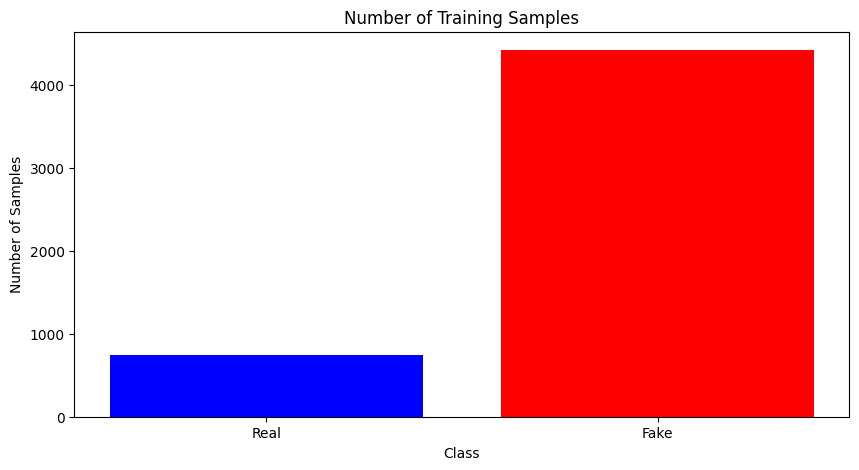

In [3]:
num_real = len(os.listdir('split_dataset/train/real'))
num_fake = len(os.listdir('split_dataset/train/fake'))

plt.figure(figsize=(10, 5))
plt.bar(['Real', 'Fake'], [num_real, num_fake], color=['blue', 'red'])
plt.title('Number of Training Samples')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

print(f"Number of training samples: {num_real + num_fake}")
print(f"Number of real samples: {num_real}")
print(f"Number of fake samples: {num_fake}")

In [4]:
common_transform = None

In [5]:
train_dir = 'split_dataset/train'
val_dir = 'split_dataset/val'
test_dir = 'split_dataset/test'

train_dataset = DatasetLoader(train_dir, common_transform=None, balance_data=True)
val_dataset = DatasetLoader(val_dir, common_transform=common_transform, balance_data=True)
test_dataset = DatasetLoader(test_dir, common_transform=common_transform, balance_data=True)

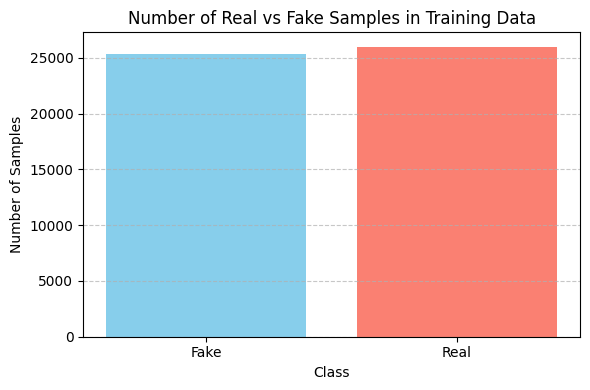

In [6]:
from collections import Counter

# Count labels from the train dataset
labels = [label for _, label in train_dataset]
counts = Counter(labels)

# Map labels to class names
class_names = {0: 'Real', 1: 'Fake'}
labels_text = [class_names[int(label)] for label in counts.keys()]
values = list(counts.values())

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels_text, values, color=['skyblue', 'salmon'])
plt.title('Number of Real vs Fake Samples in Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

## Model Training & Testing


### 1. ResNet152

In [8]:
def get_resnet_model():
    model = models.resnet152(pretrained=True)

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 2)

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_resnet_model().to(device)


/home/cs23b1069/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cs23b1069/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()

    return correct / len(loader.dataset)

def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0

        print(f"\nEpoch {epoch+1}/{epochs}")
        progress_bar = tqdm(train_loader, desc="Training", leave=False)

        total = 0
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += batch_size

            # progress_bar = tqdm(train_loader, desc="Training", leave=False, position=0)

        avg_loss = running_loss / total
        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader)
        print(f"Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")



In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_model(model, train_loader, val_loader, epochs=10)


Epoch 1/10


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Train Loss: 0.3096 | Train Acc: 0.8583 | Val Acc: 0.9047

Epoch 2/10


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Train Loss: 0.1510 | Train Acc: 0.9400 | Val Acc: 0.9219

Epoch 3/10


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Train Loss: 0.1002 | Train Acc: 0.9607 | Val Acc: 0.9279

Epoch 4/10


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Train Loss: 0.0732 | Train Acc: 0.9724 | Val Acc: 0.9324

Epoch 5/10


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Train Loss: 0.0588 | Train Acc: 0.9786 | Val Acc: 0.9331

Epoch 6/10


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Train Loss: 0.0491 | Train Acc: 0.9820 | Val Acc: 0.9316

Epoch 7/10


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Train Loss: 0.0455 | Train Acc: 0.9832 | Val Acc: 0.9379

Epoch 8/10


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Train Loss: 0.0385 | Train Acc: 0.9866 | Val Acc: 0.9264

Epoch 9/10


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Train Loss: 0.0329 | Train Acc: 0.9884 | Val Acc: 0.9329

Epoch 10/10


Training:   0%|          | 0/1603 [00:00<?, ?it/s]

Train Loss: 0.0339 | Train Acc: 0.9878 | Val Acc: 0.9399


In [11]:
torch.save(model, 'resnet152_model.pth')

In [12]:
def compute_eer(fpr, tpr):
    # Find the point where FPR is closest to 1 - TPR
    eer_threshold = np.argmin(np.abs(fpr - (1 - tpr)))
    eer = fpr[eer_threshold]
    return eer


def plot_metrics(all_labels, all_probs, all_preds):
    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.4f})".format(roc_auc_score(all_labels, all_probs)))
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label="Precision-Recall")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def test_model_advanced(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Prob of class "Fake"
            preds = outputs.argmax(dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    eer = compute_eer(fpr, tpr)

    print(f"\nAccuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"EER: {eer:.4f}")

    plot_metrics(all_labels, all_probs, all_preds)
    
    return acc, prec, auc, eer


Accuracy: 0.9416
Precision: 0.9142
AUC: 0.9877
EER: 0.0561


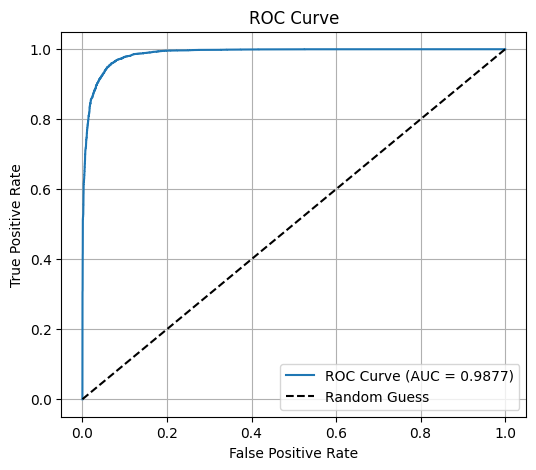

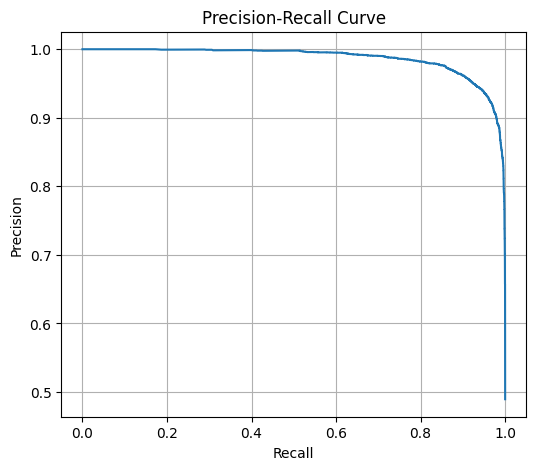

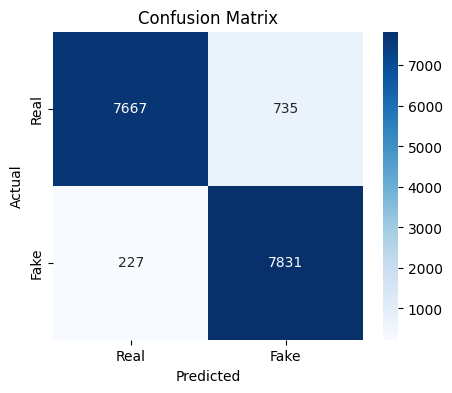

(0.9415552855407048,
 0.9141956572495914,
 0.9877363318511607,
 0.05605808140918829)

In [13]:
test_model_advanced(model, test_loader)

In [3]:
#Deep Fake detection using video

val_test_transform = None

class FrameDataset(Dataset):
    def __init__(self, frame_dir, transform=None):
        self.frame_paths = sorted([
            os.path.join(frame_dir, f)
            for f in os.listdir(frame_dir)
            if f.endswith((".jpg", ".png"))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.frame_paths)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.frame_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)["image"]
        else:
            image = torch.from_numpy(image).float() / 255.0  # Convert to float tensor
            image = image.permute(2, 0, 1)  # HWC -> CHW
        return image
    

def predict_from_frames(frame_dir, model):
    dataset = FrameDataset(frame_dir, transform=val_test_transform)
    loader = DataLoader(dataset, batch_size=16, shuffle=False)

    model.eval()
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            outputs = model(batch)
            probs = F.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())

    avg_prob = np.mean(all_probs)
    prediction = 1 if avg_prob >= 0.5 else 0
    return prediction, avg_prob


def detect_deepfake(video_path, model):
    frames = extract_frames(video_path, num_frames=30)

    #Save the images in a directory.
    os.makedirs('input_frames', exist_ok=True)
    for i, frame in enumerate(frames):
        plt.imsave(f"input_frames/frame-{i}.jpg", frame)

    prediction, confidence = predict_from_frames('input_frames', model)

    label = "Fake" if prediction else "Real"
    print(f"Prediction: {label} (Confidence: {confidence:.4f})")
    return label, confidence
    


In [17]:
#Sample Implementation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("resnet152_model.pth", map_location=device)
model = model.to(device)

detect_deepfake("sample_real.mp4", model)

/tmp/ipykernel_1803633/74214118.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("resnet152_model.pth", map_location=device)


Prediction: Real (Confidence: 0.0249)


('Real', 0.024906227)

In [18]:
detect_deepfake("sample_fake.mp4", model)

Prediction: Fake (Confidence: 0.5154)


('Fake', 0.515389)

In [8]:
detect_deepfake("sample_real.mp4", model)

Prediction: Real (Confidence: 0.0118)


('Real', 0.011806001)

### 2. ViT

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
vit = models.vision_transformer.vit_b_16(pretrained=True)

in_features = vit.heads[0].in_features

vit.heads = nn.Linear(in_features, 2)

vit = vit.to(device)

/home/cs23b1069/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cs23b1069/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
optimizer = AdamW(vit.parameters(), lr=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

criterion = nn.CrossEntropyLoss()

In [22]:
num_epochs = 10

for epoch in range(num_epochs):
    vit.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{(correct / total) * 100:.2f}%"
        })

    scheduler.step()
    
    epoch_loss = running_loss / total
    epoch_acc = (correct / total) * 100
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

Epoch [1/10]:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch [1/10] | Loss: 0.4367 | Accuracy: 77.60%


Epoch [2/10]:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch [2/10] | Loss: 0.2206 | Accuracy: 90.45%


Epoch [3/10]:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch [3/10] | Loss: 0.1321 | Accuracy: 94.58%


Epoch [4/10]:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch [4/10] | Loss: 0.0874 | Accuracy: 96.51%


Epoch [5/10]:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch [5/10] | Loss: 0.0526 | Accuracy: 98.02%


Epoch [6/10]:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch [6/10] | Loss: 0.0327 | Accuracy: 98.76%


Epoch [7/10]:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch [7/10] | Loss: 0.0189 | Accuracy: 99.33%


Epoch [8/10]:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch [8/10] | Loss: 0.0077 | Accuracy: 99.73%


Epoch [9/10]:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch [9/10] | Loss: 0.0040 | Accuracy: 99.87%


Epoch [10/10]:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch [10/10] | Loss: 0.0017 | Accuracy: 99.96%


In [23]:
vit.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit(images)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    
from sklearn.metrics import accuracy_score, classification_report

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

print(f"Accuracy: {accuracy_score(all_labels, all_preds)}")
print(classification_report(all_labels, all_preds))

Accuracy: 0.9188693749630418
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      8550
           1       0.90      0.94      0.92      8361

    accuracy                           0.92     16911
   macro avg       0.92      0.92      0.92     16911
weighted avg       0.92      0.92      0.92     16911



In [24]:
torch.save(vit.state_dict(), "vit_deepfake_model.pth")


Accuracy: 0.9132
Precision: 0.8993
AUC: 0.9616
EER: 0.0901


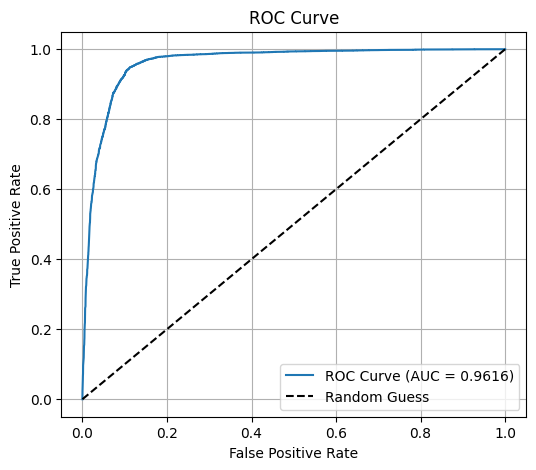

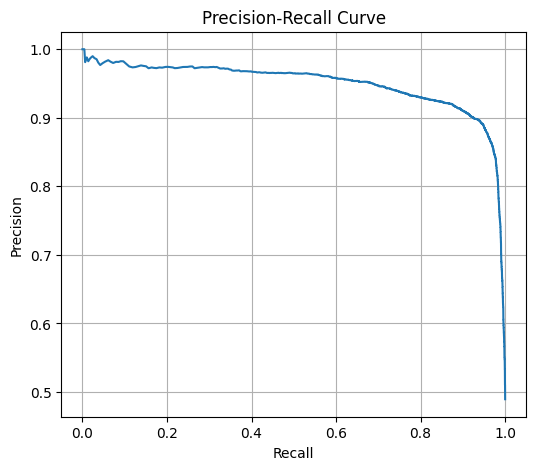

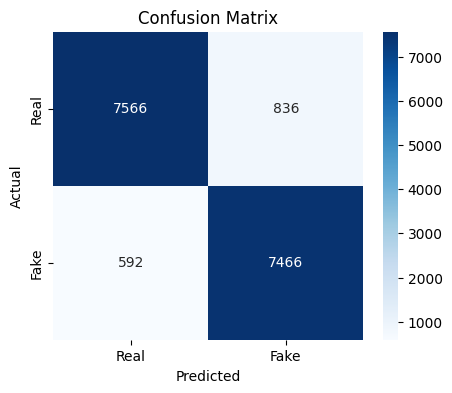

(0.9132442284325638,
 0.8993013731630932,
 0.9615987346912226,
 0.0900975958105213)

In [25]:
test_model_advanced(vit, test_loader)

### 3. Xception Net

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("xception", pretrained=True, num_classes=2)

model = model.to(device)


/home/cs23b1069/.venv/lib/python3.8/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [10]:
# Model Training
def train_xception(model, train_loader, num_epochs=10):
    model.train()
    optimizer = AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = CosineAnnealingLR(optimizer, T_max=10)

    for epoch in range(num_epochs):
        model.train()
        total_correct, total_samples = 0, 0
        epoch_loss = 0.0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
            epoch_loss += loss.item() * images.size(0)

            loop.set_postfix(loss=loss.item(), accuracy=total_correct / total_samples)

        scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss / total_samples:.4f} | Accuracy: {total_correct / total_samples:.4f}")

In [11]:
train_xception(model, train_loader, num_epochs=10)
torch.save(model.state_dict(), "xception_deepfake_model.pth")

Epoch 1/10:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 0.3160 | Accuracy: 0.8530


Epoch 2/10:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch 2/10 | Loss: 0.1289 | Accuracy: 0.9481


Epoch 3/10:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch 3/10 | Loss: 0.0754 | Accuracy: 0.9712


Epoch 4/10:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch 4/10 | Loss: 0.0479 | Accuracy: 0.9825


Epoch 5/10:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch 5/10 | Loss: 0.0273 | Accuracy: 0.9900


Epoch 6/10:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch 6/10 | Loss: 0.0171 | Accuracy: 0.9936


Epoch 7/10:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch 7/10 | Loss: 0.0105 | Accuracy: 0.9960


Epoch 8/10:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch 8/10 | Loss: 0.0057 | Accuracy: 0.9979


Epoch 9/10:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch 9/10 | Loss: 0.0030 | Accuracy: 0.9988


Epoch 10/10:   0%|          | 0/1603 [00:00<?, ?it/s]

Epoch 10/10 | Loss: 0.0019 | Accuracy: 0.9991



Accuracy: 0.9391
Precision: 0.9114
AUC: 0.9786
EER: 0.0664


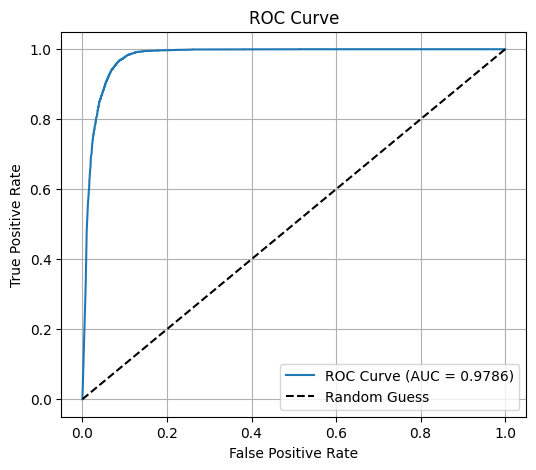

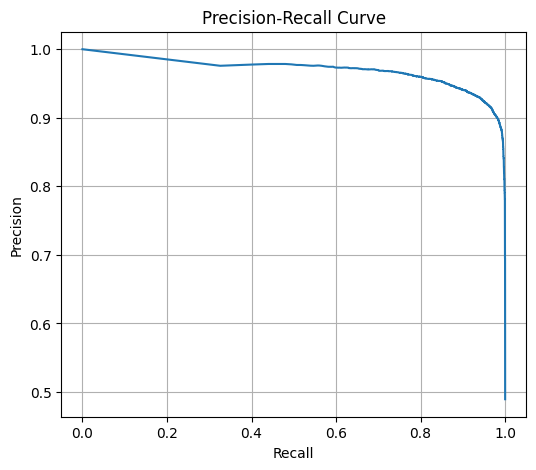

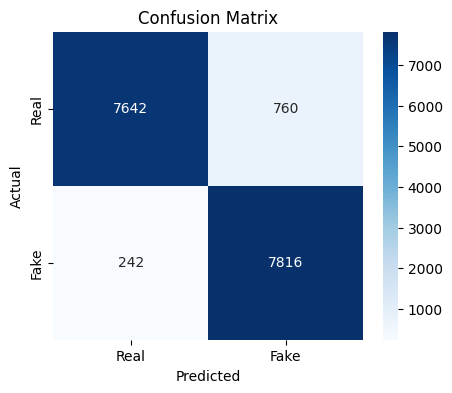

(0.9391251518833535,
 0.9113805970149254,
 0.9785548170195977,
 0.06641275886693644)

In [13]:
test_model_advanced(model, test_loader)

### 4. Optical Flow

In [7]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset

class OpticalFlowDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for label, cls in enumerate(['real', 'fake']):
            class_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(class_dir):
                if fname.endswith('.mp4'):
                    self.samples.append((os.path.join(class_dir, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]

        cap = cv2.VideoCapture(video_path)
        ret, prev = cap.read()

        if not ret:
            raise ValueError(f"Could not read {video_path}")

        prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
        flow_frames = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None,
                                                 0.5, 3, 15, 3, 5, 1.2, 0)
            flow = cv2.resize(flow, (224, 224))  # resize for model input
            flow_frames.append(flow)
            prev_gray = gray

        cap.release()

        # Stack or select fixed number of frames
        flow_tensor = np.stack(flow_frames[:10])  # Use only first 10 for speed
        flow_tensor = torch.tensor(flow_tensor).permute(0, 3, 1, 2).float()  # T, C, H, W

        if self.transform:
            flow_tensor = self.transform(flow_tensor)

        return flow_tensor, label


In [8]:
import torch.nn as nn

class OpticalFlowCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(2, 16, kernel_size=(3, 3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 10 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        # x: (B, T, C, H, W) → reshape to (B, C, T, H, W)
        x = x.permute(0, 2, 1, 3, 4)
        x = self.conv(x)
        x = self.fc(x)
        return x


In [12]:
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, roc_auc_score,
    confusion_matrix, classification_report
)
import torch.optim as optim
from tqdm import tqdm

# Dataset & Loader
dataset = OpticalFlowDataset("")
loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Model
model = OpticalFlowCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(10):
    model.train()
    y_true, y_pred, y_score = [], [], []
    running_loss = 0

    for x, y in tqdm(loader):
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        probs = torch.softmax(out, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probs[:, 1].detach().cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\nEpoch {epoch+1}")
    print(f"Loss: {running_loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"ROC-AUC: {auc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_true, y_pred))


100%|██████████| 681/681 [12:14:11<00:00, 64.69s/it]   



Epoch 1
Loss: 480.9683
Accuracy: 0.6194
Precision: 0.6328
ROC-AUC: 0.6158
Confusion Matrix:
 [[183 383]
 [135 660]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.32      0.41       566
           1       0.63      0.83      0.72       795

    accuracy                           0.62      1361
   macro avg       0.60      0.58      0.57      1361
weighted avg       0.61      0.62      0.59      1361



  3%|▎         | 22/681 [24:30<12:14:01, 66.83s/it]


KeyboardInterrupt: 